In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd



columns = ["age" ,      
      "sex"    ,
      "chest pain type"  ,       
      "resting blood pressure" ,
      "serum cholestoral in mg/dl",      
      "fasting blood sugar > 120 mg/dl",       
      "resting electrocardiographic results",  
      "maximum heart rate achieved" , 
      "exercise induced angina"    ,
      "oldpeak = ST depression induced by exercise relative to rest"  , 
      "the slope of the peak exercise ST segment"     ,
      "number of major vessels (0-3) colored by flourosopy",        
       "thal", "target"]
data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat",header=None, sep=" ")
data.columns=columns

categorical_columns = ['sex', 'chest pain type','fasting blood sugar > 120 mg/dl',"resting electrocardiographic results","thal","exercise induced angina"]

for c in categorical_columns:
      data[c] = data[c].astype('category')
else:
      data[c] = data[c].astype(float)

data["target"] = np.where(data["target"]==2,1,0)

features = [c for c in columns if c !='target']
X = data[features]




y = data['target']

In [3]:
X

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,thal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [19]:
from scorepyo.preprocessing import AutoBinarizer


binarizer = AutoBinarizer(max_number_binaries_by_features=3, keep_negative=True)
binarizer.fit(X_train, y_train, categorical_features=categorical_columns, to_exclude_features=None)

X_train_binarized = binarizer.transform_bis(X_train)
X_test_binarized, _ = binarizer.transform(X_test)

In [6]:
# binarizer.df_score_feature

In [7]:
from scorepyo.models import EBMRiskScore, OptunaRiskScore

ebm_model = EBMRiskScore()
scorepyo_model = OptunaRiskScore(
    # df_info=df_info["feature"].reset_index()
)

scorepyo_model.fit(X_train_binarized, y_train)
ebm_model.fit(X_train, y_train, categorical_features=categorical_columns)

In [8]:
ebm_model.summary()

| FEATURE-POINT CARD |
| Feature                                                    | Description                                                | Point(s)   |       |
|:-----------------------------------------------------------|:-----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5  | number of major vessels (0-3) colored by flourosopy < 0.5  | -1         | ...   |
| number of major vessels (0-3) colored by flourosopy >= 1.5 | number of major vessels (0-3) colored by flourosopy >= 1.5 | 1          | + ... |
| chest pain type_4.0                                        | chest pain type_4.0                                        | 1          | + ... |
| thal_7.0                                                   | thal_7.0                                                   | 1          | + ... |
|                                                            |                                             

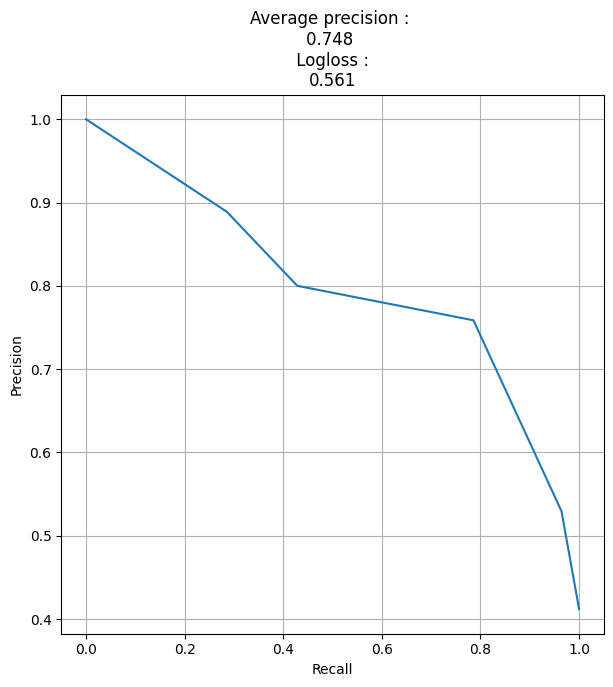

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [10]:
# # TODO : put support of the binary feature to favor large plateau
# df_info['abs_contribution'] = df_info['EBM_log_odds_contribution'].abs()*df_info['density']
# nb_max_features = 5
# top_features = df_info.sort_values(by='abs_contribution', ascending=False).index[:nb_max_features]
# # selected_binary_features = pd.concat([top_features,pd.DataFrame(df_info.loc['intercept',:]).T],axis=0)
# top_features = top_features.append(pd.Index(['intercept']))
# df_info_modified = df_info.copy()
# df_info_modified['EBM_log_odds_contribution'] = np.where(df_info_modified.index.isin(top_features),df_info_modified['EBM_log_odds_contribution'] ,0)
# df_info_modified

In [11]:

# max_point_value = 2
# max_value_multipliers = max_point_value/df_info_modified['EBM_log_odds_contribution'].fillna(0).abs().max()

# min_value_multipliers = 0.5 if max_value_multipliers == 1 else 1
# n_multipliers = 20
# list_multipliers = np.linspace(min_value_multipliers, max_value_multipliers, n_multipliers)

# w_original = df_info_modified['EBM_log_odds_contribution'].values


In [12]:
# matrix_w_multiplied = w_original.reshape(-1,1)*list_multipliers.reshape(1,-1)
# y_train_fasterrisk = np.where(y_train==1,1,-1)
# # X_train_binarized_augmented = np.concatenate([X_train_binarized.values,np.ones((len(X_train_binarized),1))], axis=1)
# best_log_loss = 1000
# best_w = None
# best_m = None
# best_intercept = None
# for j in range(n_multipliers):
#     X_train_binarized_augmented = np.concatenate([X_train_binarized.values/list_multipliers[j],np.ones((len(X_train_binarized),1))], axis=1)
#     w_multiplied = matrix_w_multiplied[:,j]
#     w_multiplied = w_multiplied.reshape(-1,1)
#     J = [j1 for j1,val in enumerate(w_multiplied) if np.ceil(val)!=np.floor(val)]
#     # print(w_multiplied)
#     w_multiplied_floor = np.floor(w_multiplied)
#     w_multiplied_ceil = np.ceil(w_multiplied)
#     gamma = np.repeat(w_multiplied_floor.T, repeats=len(X_train), axis=0)
    
#     Z = np.einsum('ij,i->ij',X_train_binarized_augmented,y_train_fasterrisk)
#     gamma = gamma+(Z<=0)
#     gamma = gamma.astype(float)
#     xGamma_sum = np.einsum('ij,ij->i',X_train_binarized_augmented,gamma)
#     denominator_part = np.einsum('i,i->i',y_train_fasterrisk, xGamma_sum)
#     l = 1/(1+np.exp(denominator_part))

#     while len(J) > 0 :
#         U = dict()
#         for j1 in J:
#             w_j_up = w_multiplied.copy()
#             w_j_up[j1,:] = np.ceil(w_multiplied[j1,:])
#             lX = np.einsum('i,ij->ij',l,X_train_binarized_augmented)
#             substract_up = (w_j_up-w_multiplied).astype(float)
#             U_j_up = np.sum(np.einsum('ij,jk->ik',lX,substract_up)**2)

#             w_j_down = w_multiplied.copy()
#             w_j_down[j1,:] = np.floor(w_multiplied[j1,:])
#             substract_down = (w_j_down-w_multiplied).astype(float)
#             U_j_down = np.sum(np.einsum('ij,jk->ik',lX,substract_down)**2)
#             U[j1] = {'up':U_j_up, 'down':U_j_down}

#         j_up, U_up = min([(j1,U[j1]['up']) for j1 in J], key=lambda t:t[1])
#         j_down, U_down = min([(j1,U[j1]['down']) for j1 in J], key=lambda t:t[1])
#         if U_up <= U_down:
#             J =[j1 for j1 in J if j1!=j_up]
#             w_multiplied[j_up] = np.ceil(w_multiplied[j_up])
#         else:
#             J =[j1 for j1 in J if j1!=j_down]
#             w_multiplied[j_down] = np.floor(w_multiplied[j_down])
#         # break

#     w_multiplied_features = w_multiplied[:-1]
#     w_multiplied_intercept = w_multiplied[-1]
#     # w_multiplied_features, w_multiplied_intercept
#     XW = (np.einsum('ij,jk->ik',X_train_binarized_augmented.astype(float),w_multiplied.astype(float)))
#     logloss = np.mean(1+np.exp(np.einsum('i,ik->i', -y_train_fasterrisk, XW)))
#     if logloss < best_log_loss:
#         best_log_loss = logloss
#         best_intercept = w_multiplied_intercept
#         best_w = w_multiplied_features
#         best_m = list_multipliers[j]

#     # l = 
#     # break

In [13]:
# y_train_score = (np.einsum('ij,jk->i',X_train_binarized.values, best_w.astype(float))+best_intercept)/best_m
# y_train_pred_prob = 1/(1+np.exp(-y_train_score.astype(float)))
# y_train_pred_prob

# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


# y_proba = y_train_pred_prob.reshape(-1, 1)

# precision, recall, thresholds = precision_recall_curve(y_train.astype(int), y_proba)
# fig, ax = plt.subplots(figsize=(7, 7))
# plt.plot(recall, precision)
# average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
# logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
# title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
# plt.title(title_PR_curve)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.grid()
# plt.show()

In [15]:
from scorepyo.models import OptunaRiskScore


scorepyo_model = OptunaRiskScore(
    nb_max_features=4,
    min_point_value=-1,
    max_point_value=2,
    # df_info=df_info["feature"].reset_index(),
    optuna_optimize_params={"n_trials":100, "timeout":30}
)

# print('Number of combinations:',scorepyo_model.nb_max_features**(X.shape[1]*(scorepyo_model.max_point_value-scorepyo_model.min_point_value)))

Number of combinations: 302231454903657293676544


In [16]:


scorepyo_model.fit(X_train_binarized, y_train)

In [17]:
scorepyo_model.summary()

| FEATURE-POINT CARD |
| Feature                              | Description                          | Point(s)   |       |
|:-------------------------------------|:-------------------------------------|:-----------|:------|
| age < 50.5                           | age < 50.5                           | -1         | ...   |
| chest pain type_2.0                  | chest pain type_2.0                  | -1         | + ... |
| maximum heart rate achieved >= 161.5 | maximum heart rate achieved >= 161.5 | -1         | + ... |
| sex_1.0                              | sex_1.0                              | 1          | + ... |
|                                      |                                      | SCORE=     | ...   |


|     SCORE CARD     |
| SCORE   | -3    | -2    | -1     | 0      | 1      |
|:--------|:------|:------|:-------|:-------|:-------|
| RISK    | 2.93% | 7.59% | 18.24% | 37.75% | 62.25% |


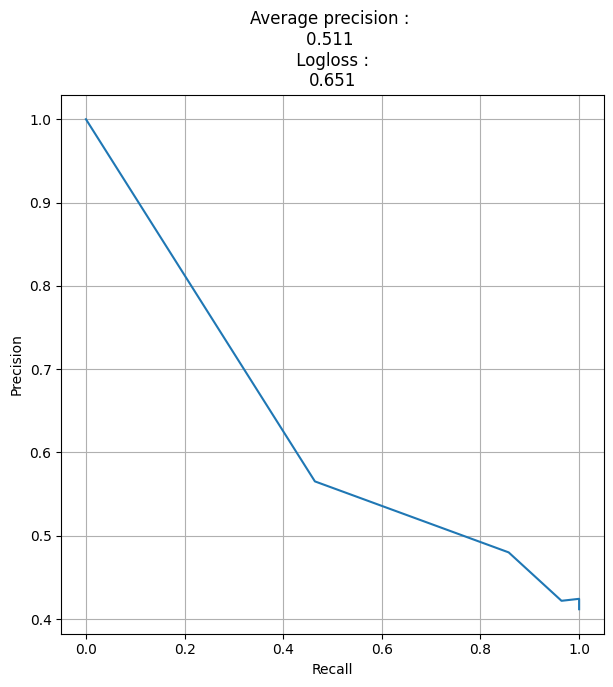

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


y_proba = scorepyo_model.predict_proba(X_test_binarized)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [21]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(scorepyo_model._study)

In [22]:
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

sparsity = 4
parent_size = 10
y_train_fasterrisk = np.where(y_train==0,-1,1)
RiskScoreOptimizer_m = RiskScoreOptimizer(X = X_train_binarized.values, y = y_train_fasterrisk, lb=-1, ub=2,k = 4, parent_size = parent_size)

In [23]:
RiskScoreOptimizer_m.optimize()

In [24]:
multipliers, sparseDiversePool_beta0_integer, sparseDiversePool_betas_integer = RiskScoreOptimizer_m.get_models()

(202, 50)


In [25]:
model_index = 0 # first model
multiplier = multipliers[model_index]
intercept = sparseDiversePool_beta0_integer[model_index]
coefficients = sparseDiversePool_betas_integer[model_index]

In [26]:
RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)

In [27]:
y_test_pred_prob = RiskScoreClassifier_m.predict_prob(X_test_binarized)

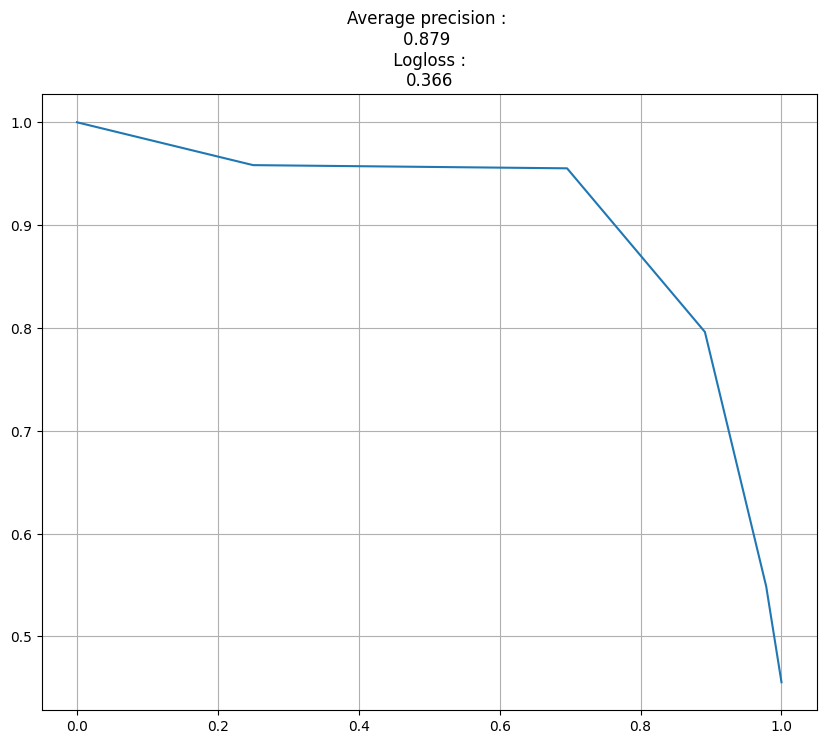

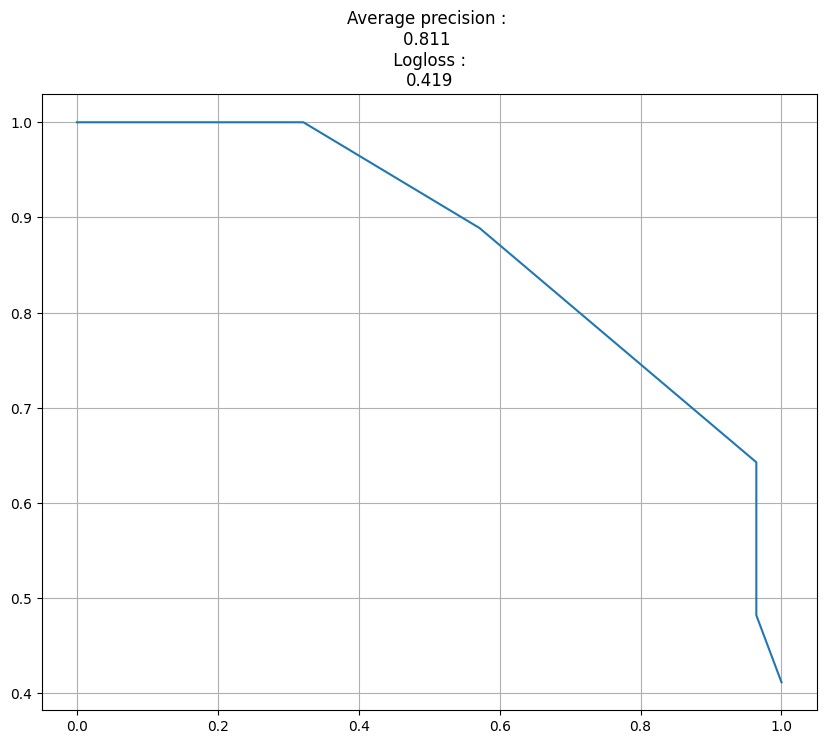

The Risk Score is:
1.                             the slope of the peak exercise ST segment < 1.5     -1 point(s) |   ...
2.                   number of major vessels (0-3) colored by flourosopy < 0.5     -1 point(s) | + ...
3.                                                         chest pain type_4.0      1 point(s) | + ...
4.                                                                    thal_7.0      1 point(s) | + ...
                                                                                         SCORE | =    
SCORE |  -2.0  |  -1.0  |   0.0  |
RISK  |   5.7% |  19.7% |  50.0% |
SCORE |   1.0  |   2.0  |
RISK  |  80.3% |  94.3% |


In [32]:
y_proba = RiskScoreClassifier_m.predict_prob(X_train_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()

y_proba = RiskScoreClassifier_m.predict_prob(X_test_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()

X_featureNames = list(X_train_binarized.columns[:])

RiskScoreClassifier_m.reset_featureNames(X_featureNames)
RiskScoreClassifier_m.print_model_card()

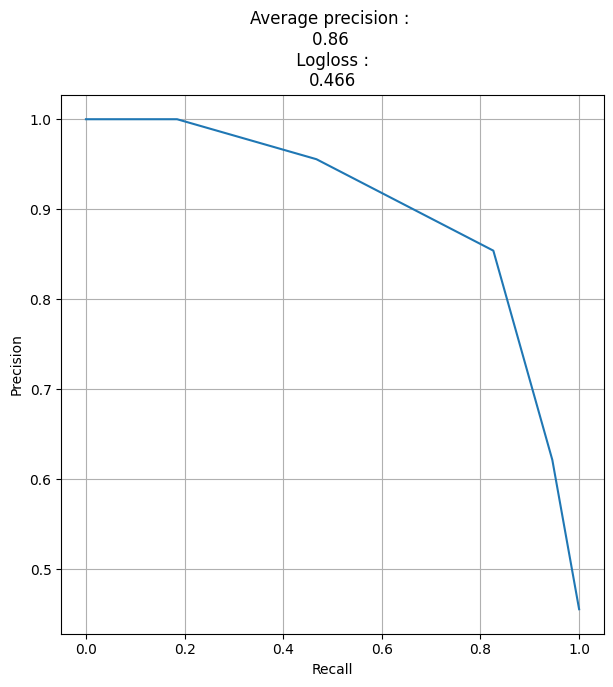

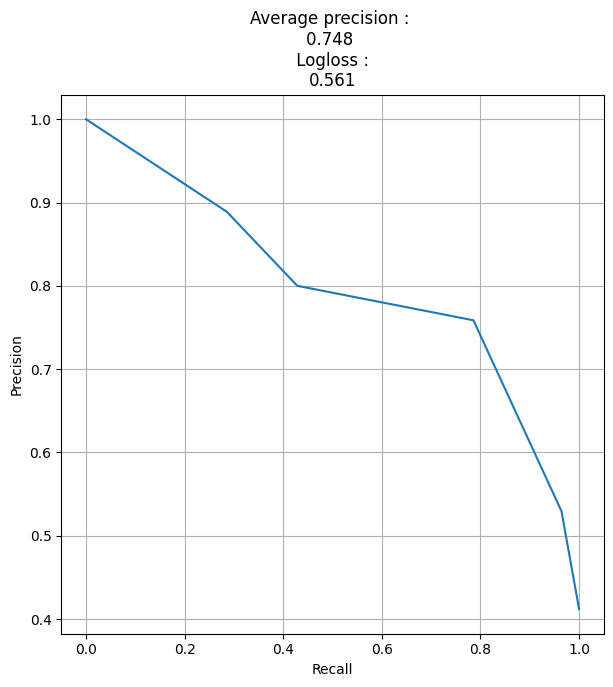

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss

y_proba = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_train.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()